# Example 1: Synthetic Paired Gaussians on a Shared Manifold

<>:142: SyntaxWarning: invalid escape sequence '\m'
<>:142: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3754803997.py:142: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title("Raw inputs in $\mathbb{R}^2$")


Epoch 050 | loss = 3.7177
Epoch 100 | loss = 3.5222
Epoch 150 | loss = 3.4872
Epoch 200 | loss = 3.4626


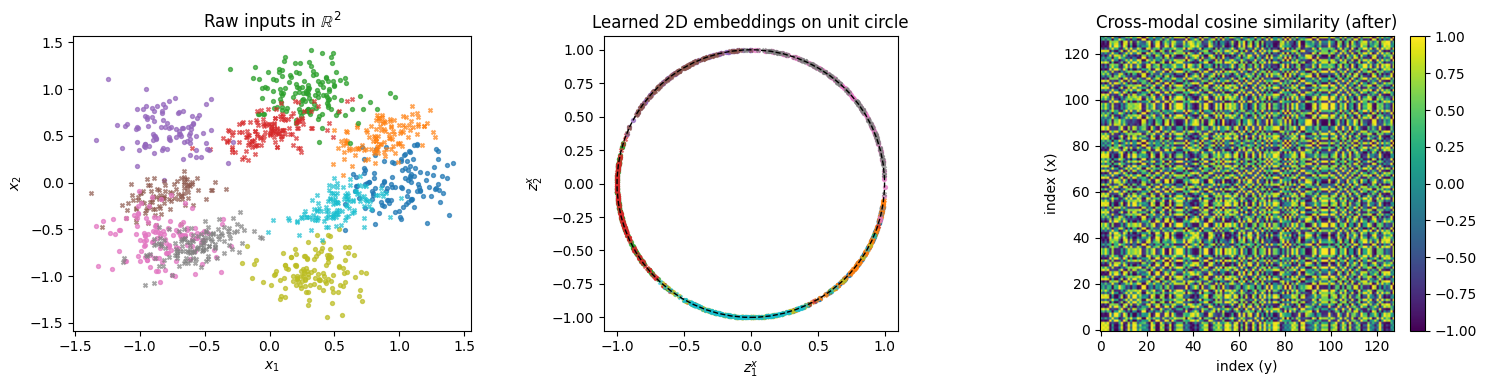

/tmp/ipython-input-3754803997.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


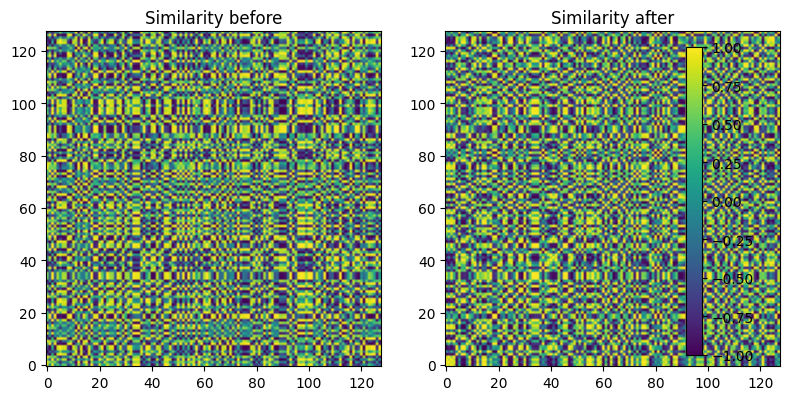

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# -----------------------------
# 1. Synthetic data generation
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)

N = 2000        # total number of points
K = 5           # number of clusters
sigma = 0.2     # within-cluster noise
delta = 0.05    # noise for second view

# cluster means on a circle
angles = np.linspace(0, 2 * np.pi, K, endpoint=False)
mu = np.stack([np.cos(angles), np.sin(angles)], axis=1)  # shape (K, 2)

# random linear transform A for second view
theta = np.pi / 6
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
S = np.diag([1.0, 0.5])
A = R @ S  # rotation + anisotropic scaling

X = []
Y = []
labels = []

for i in range(N):
    c = np.random.randint(0, K)      # choose cluster
    s = np.random.randn(2) * sigma + mu[c]      # latent
    x = s
    y = A @ s + np.random.randn(2) * delta
    X.append(x)
    Y.append(y)
    labels.append(c)

X = np.stack(X)      # (N, 2)
Y = np.stack(Y)      # (N, 2)
labels = np.array(labels)

# convert to tensors
X_t = torch.from_numpy(X).float()
Y_t = torch.from_numpy(Y).float()

# -----------------------------
# 2. Tiny dual encoders + InfoNCE
# -----------------------------
class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=64, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        z = self.net(x)
        return F.normalize(z, dim=-1)

def clip_loss(zx, zy, temp=0.07):
    logits = zx @ zy.T / temp   # (B,B)
    labels = torch.arange(zx.size(0), device=zx.device)
    loss_xy = F.cross_entropy(logits, labels)
    loss_yx = F.cross_entropy(logits.T, labels)
    return 0.5 * (loss_xy + loss_yx)

f = MLP()  # encoder for x
g = MLP()  # encoder for y
opt = torch.optim.Adam(list(f.parameters()) + list(g.parameters()), lr=1e-3)

batch_size = 256
epochs = 200

def get_batches(X, Y, batch_size):
    N = X.size(0)
    idx = torch.randperm(N)
    for i in range(0, N, batch_size):
        j = idx[i:i+batch_size]
        yield X[j], Y[j]

# -----------------------------
# 3. Train
# -----------------------------
for ep in range(epochs):
    running = 0.0
    count = 0
    for xb, yb in get_batches(X_t, Y_t, batch_size):
        zx = f(xb)
        zy = g(yb)
        loss = clip_loss(zx, zy, temp=0.07)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item()
        count += 1
    if (ep + 1) % 50 == 0:
        print(f"Epoch {ep+1:03d} | loss = {running / max(1, count):.4f}")

# -----------------------------
# 4. Compute embeddings before/after & similarity matrices
# -----------------------------
with torch.no_grad():
    Zx = f(X_t).numpy()  # (N,2)
    Zy = g(Y_t).numpy()  # (N,2)

# sample a subset for visualization (otherwise plots get dense)
idx_vis = np.random.choice(N, size=600, replace=False)
X_vis = X[idx_vis]
Y_vis = Y[idx_vis]
Zx_vis = Zx[idx_vis]
Zy_vis = Zy[idx_vis]
labels_vis = labels[idx_vis]

# similarity matrices (take a smaller subset to keep them readable)
idx_sim = np.random.choice(N, size=128, replace=False)
with torch.no_grad():
    zx_sim = f(X_t[idx_sim]).numpy()
    zy_sim = g(Y_t[idx_sim]).numpy()

# before training similarity: use raw X,Y normalized
X_norm = X_t[idx_sim] / X_t[idx_sim].norm(dim=-1, keepdim=True)
Y_norm = Y_t[idx_sim] / Y_t[idx_sim].norm(dim=-1, keepdim=True)
S_before = (X_norm @ Y_norm.T).numpy()
S_after  = (torch.from_numpy(zx_sim) @ torch.from_numpy(zy_sim).T).numpy()

# -----------------------------
# 5. Plot: raw space, learned space, similarity matrices
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Left: raw space
ax = axes[0]
for k in range(K):
    mask = labels_vis == k
    ax.scatter(X_vis[mask, 0], X_vis[mask, 1], s=8, alpha=0.7, label=f"cluster {k} (x)")
    ax.scatter(Y_vis[mask, 0], Y_vis[mask, 1], s=8, alpha=0.7, marker='x')
ax.set_title("Raw inputs in $\mathbb{R}^2$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# Middle: learned embeddings on unit circle
ax = axes[1]
for k in range(K):
    mask = labels_vis == k
    ax.scatter(Zx_vis[mask, 0], Zx_vis[mask, 1], s=8, alpha=0.7, label=f"cluster {k} (x)")
    ax.scatter(Zy_vis[mask, 0], Zy_vis[mask, 1], s=8, alpha=0.7, marker='x')
circle = plt.Circle((0, 0), 1.0, fill=False, linestyle='--')
ax.add_artist(circle)
ax.set_aspect('equal', 'box')
ax.set_title("Learned 2D embeddings on unit circle")
ax.set_xlabel("$z^x_1$")
ax.set_ylabel("$z^x_2$")

# Right: similarity matrices
im0 = axes[2].imshow(S_after, vmin=-1, vmax=1, origin='lower')
axes[2].set_title("Cross-modal cosine similarity (after)")
axes[2].set_xlabel("index (y)")
axes[2].set_ylabel("index (x)")
fig.colorbar(im0, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# You can also plot S_before vs S_after in a 2x2 panel if you like:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
im1 = ax1.imshow(S_before, vmin=-1, vmax=1, origin='lower')
ax1.set_title("Similarity before")
im2 = ax2.imshow(S_after, vmin=-1, vmax=1, origin='lower')
ax2.set_title("Similarity after")
fig2.colorbar(im2, ax=[ax1, ax2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1646112018.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", K)


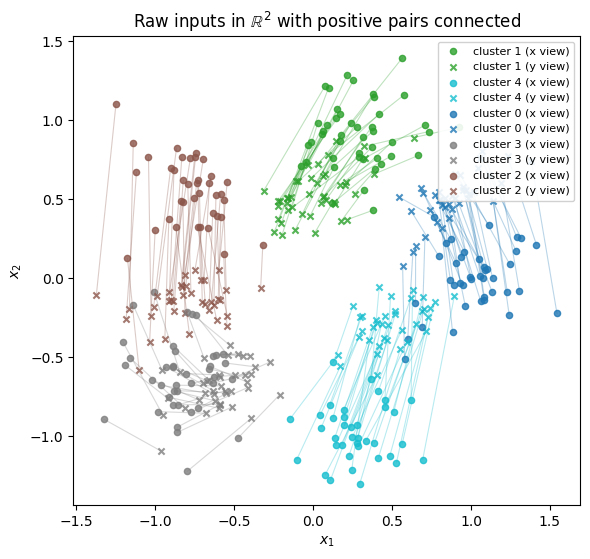

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

cmap = plt.cm.get_cmap("tab10", K)
seen_x = set()
seen_y = set()

for i, idx in enumerate(idx_vis):
    c = labels[idx]
    color = cmap(c)

    # only label each cluster once for x-view
    label_x = f"cluster {c} (x view)" if c not in seen_x else None
    ax.scatter(
        X_vis[i, 0], X_vis[i, 1],
        s=20, color=color, alpha=0.8,
        label=label_x,
    )
    seen_x.add(c)

    # only label each cluster once for y-view
    label_y = f"cluster {c} (y view)" if c not in seen_y else None
    ax.scatter(
        Y_vis[i, 0], Y_vis[i, 1],
        s=20, color=color, alpha=0.8, marker="x",
        label=label_y,
    )
    seen_y.add(c)

    # line connecting the positive pair
    ax.plot(
        [X_vis[i, 0], Y_vis[i, 0]],
        [X_vis[i, 1], Y_vis[i, 1]],
        color=color, alpha=0.3, linewidth=0.8,
    )

ax.set_aspect("equal", "box")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Raw inputs in $\\mathbb{R}^2$ with positive pairs connected")
ax.legend(fontsize=8, loc="upper right", framealpha=0.9)
plt.tight_layout()
plt.show()


/tmp/ipython-input-344040740.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", K)


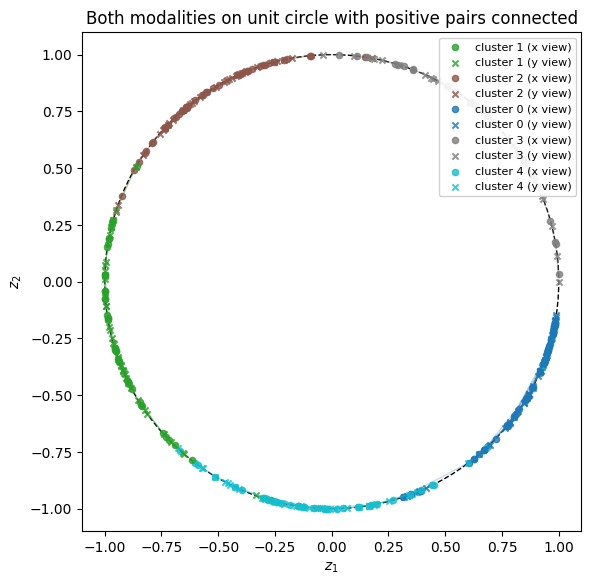

In [ ]:
# -----------------------------------------
# NEW: visualize both modalities together (CLIP embeddings)
# -----------------------------------------
with torch.no_grad():
    Zx = f(X_t).numpy()  # (N, 2)
    Zy = g(Y_t).numpy()  # (N, 2)

# pick a subset so the plot is readable
# (if you want this to match the raw plot exactly, reuse the same idx_vis there)
idx_vis = np.random.choice(N, size=200, replace=False)
Zx_vis = Zx[idx_vis]
Zy_vis = Zy[idx_vis]
labels_vis = labels[idx_vis]

fig, ax = plt.subplots(figsize=(6, 6))

# draw unit circle
circle = plt.Circle((0, 0), 1.0, fill=False, linestyle='--')
ax.add_artist(circle)

cmap = plt.cm.get_cmap("tab10", K)
seen_x = set()
seen_y = set()

for i, idx in enumerate(idx_vis):
    c = labels[idx]
    color = cmap(c)

    # x-modality embedding: circle marker
    label_x = f"cluster {c} (x view)" if c not in seen_x else None
    ax.scatter(
        Zx_vis[i, 0], Zx_vis[i, 1],
        s=20, color=color, alpha=0.8,
        label=label_x,
    )
    seen_x.add(c)

    # y-modality embedding: cross marker
    label_y = f"cluster {c} (y view)" if c not in seen_y else None
    ax.scatter(
        Zy_vis[i, 0], Zy_vis[i, 1],
        s=20, color=color, alpha=0.8, marker="x",
        label=label_y,
    )
    seen_y.add(c)

    # line connecting the positive pair (x_i, y_i)
    ax.plot(
        [Zx_vis[i, 0], Zy_vis[i, 0]],
        [Zx_vis[i, 1], Zy_vis[i, 1]],
        color=color, alpha=0.3, linewidth=0.8,
    )

ax.set_aspect("equal", "box")
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
ax.set_title("Both modalities on unit circle with positive pairs connected")

ax.legend(fontsize=8, loc="upper right", framealpha=0.9)
plt.tight_layout()
plt.show()


## Example 2: MNIST Digit Images with Augmented Views as Paired Modalities

100%|██████████| 9.91M/9.91M [00:00<00:00, 61.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.65MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 001 | loss = 3.7964
Epoch 002 | loss = 2.3045
Epoch 003 | loss = 1.9439
Epoch 004 | loss = 1.7271
Epoch 005 | loss = 1.5752
Epoch 006 | loss = 1.4637
Epoch 007 | loss = 1.3817
Epoch 008 | loss = 1.3072
Epoch 009 | loss = 1.2450
Epoch 010 | loss = 1.1984
Epoch 011 | loss = 1.1540
Epoch 012 | loss = 1.1177
Epoch 013 | loss = 1.0819
Epoch 014 | loss = 1.0567
Epoch 015 | loss = 1.0301
Epoch 016 | loss = 1.0019
Epoch 017 | loss = 0.9799
Epoch 018 | loss = 0.9557
Epoch 019 | loss = 0.9439
Epoch 020 | loss = 0.9188
Epoch 021 | loss = 0.9007
Epoch 022 | loss = 0.8872
Epoch 023 | loss = 0.8656
Epoch 024 | loss = 0.8508
Epoch 025 | loss = 0.8343
Epoch 026 | loss = 0.8249
Epoch 027 | loss = 0.8108
Epoch 028 | loss = 0.7989
Epoch 029 | loss = 0.7867
Epoch 030 | loss = 0.7749
Epoch 031 | loss = 0.7706
Epoch 032 | loss = 0.7527
Epoch 033 | loss = 0.7469
Epoch 034 | loss = 0.7400
Epoch 035 | loss = 0.7302
Epoch 036 | loss = 0.7259
Epoch 037 | loss = 0.7176
Epoch 038 | loss = 0.7134
Epoch 039 | 

/tmp/ipython-input-900503591.py:227: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)


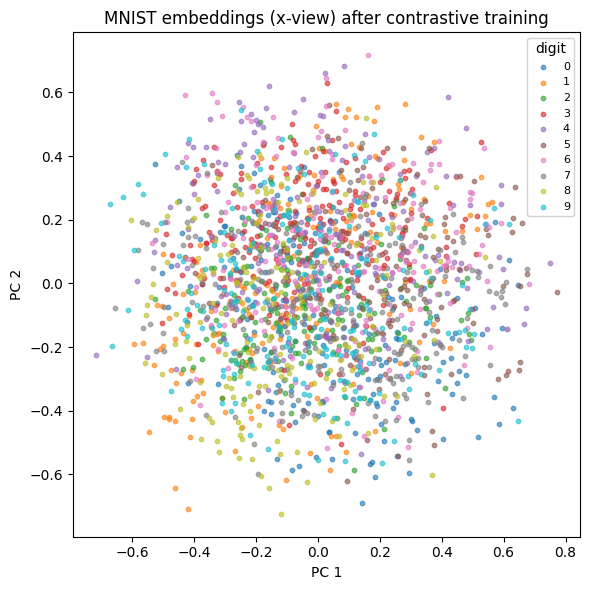

/tmp/ipython-input-900503591.py:296: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


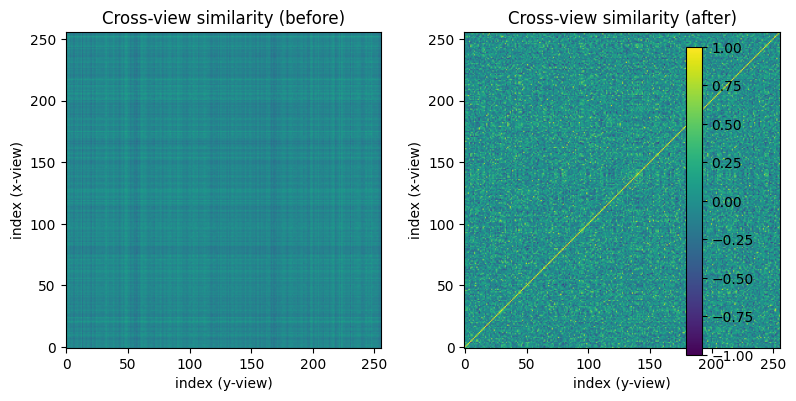

In [ ]:
"""
Requirements:
    pip install torch torchvision matplotlib scikit-learn
"""

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# -----------------------------
# 1. Reproducibility
# -----------------------------
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


# -----------------------------
# 2. Paired MNIST dataset
# -----------------------------
class PairedMNIST(Dataset):
    """
    For each MNIST image u_i, returns two independent augmentations:
        x_i = Augment_1(u_i)
        y_i = Augment_2(u_i)
    plus the digit label for visualization (not used in training).
    """

    def __init__(self, root, train=True):
        self.base = datasets.MNIST(
            root=root,
            train=train,
            download=True,
            transform=transforms.ToTensor(),  # just to [0,1] tensor
        )
        # augmentation hyperparams
        self.max_deg = 20
        self.max_trans = 3       # pixels
        self.noise_std = 0.05
        self.min_contrast = 0.5
        self.max_contrast = 1.3

    def _augment(self, img):
        """
        img: 1x28x28 tensor
        Apply random rotation, translation, contrast, and Gaussian noise.
        """
        # random rotation
        angle = random.uniform(-self.max_deg, self.max_deg)
        # random translation in pixels
        translate_x = random.randint(-self.max_trans, self.max_trans)
        translate_y = random.randint(-self.max_trans, self.max_trans)

        img = TF.rotate(img, angle, interpolation=transforms.InterpolationMode.BILINEAR)
        img = TF.affine(
            img,
            angle=0.0,
            translate=(translate_x, translate_y),
            scale=1.0,
            shear=0.0,
            interpolation=transforms.InterpolationMode.BILINEAR,
        )

        # random contrast scaling
        contrast_factor = random.uniform(self.min_contrast, self.max_contrast)
        img = TF.adjust_contrast(img, contrast_factor)

        # add Gaussian noise
        noise = torch.randn_like(img) * self.noise_std
        img = img + noise
        img = torch.clamp(img, 0.0, 1.0)

        return img

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]  # img in [0,1], shape (1,28,28)
        x = self._augment(img)
        y = self._augment(img)
        return x, y, label


# -----------------------------
# 3. Dual encoders + InfoNCE
# -----------------------------
class MLPEncoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512, proj_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, proj_dim),
        )

    def forward(self, x):
        # x: (B, 1, 28, 28)
        x = x.view(x.size(0), -1)  # flatten to (B,784)
        z = self.net(x)
        z = F.normalize(z, dim=-1)  # L2-normalize
        return z


def symmetric_clip_loss(zx, zy, temp=0.1):
    """
    zx, zy: (B, d) normalized embeddings
    symmetric InfoNCE / CLIP loss.
    """
    logits = zx @ zy.T / temp  # (B, B)
    labels = torch.arange(zx.size(0), device=zx.device)
    loss_xy = F.cross_entropy(logits, labels)
    loss_yx = F.cross_entropy(logits.T, labels)
    return 0.5 * (loss_xy + loss_yx)


# -----------------------------
# 4. Training setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset & dataloader
train_dataset = PairedMNIST(root="./data", train=True)
train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

# encoders
f = MLPEncoder(input_dim=784, hidden_dim=512, proj_dim=32).to(device)
g = MLPEncoder(input_dim=784, hidden_dim=512, proj_dim=32).to(device)

optimizer = torch.optim.Adam(
    list(f.parameters()) + list(g.parameters()),
    lr=1e-3,
)

EPOCHS = 50
TEMP = 0.1


# -----------------------------
# 5. Train loop
# -----------------------------
for ep in range(EPOCHS):
    f.train()
    g.train()
    running_loss = 0.0
    count = 0

    for xb, yb, _ in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        z_x = f(xb)
        z_y = g(yb)

        loss = symmetric_clip_loss(z_x, z_y, temp=TEMP)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        count += 1

    avg_loss = running_loss / max(1, count)
    print(f"Epoch {ep+1:03d} | loss = {avg_loss:.4f}")


# -----------------------------
# 6. Build embeddings for visualization
# -----------------------------
# use a subset of the training set for plotting
f.eval()
g.eval()

subset_size = 2000
indices = np.random.choice(len(train_dataset), size=subset_size, replace=False)

xs = []
ys = []
labels = []

with torch.no_grad():
    for idx in indices:
        x, y, lbl = train_dataset[idx]
        xs.append(x)
        ys.append(y)
        labels.append(lbl)

    xs = torch.stack(xs).to(device)  # (subset_size, 1, 28, 28)
    ys = torch.stack(ys).to(device)

    z_x = f(xs).cpu().numpy()
    z_y = g(ys).cpu().numpy()
    labels = np.array(labels)


# -----------------------------
# 7. PCA visualization
# -----------------------------
# We embed only the x-view for clarity; you can also plot y-view or both.
pca = PCA(n_components=2, random_state=SEED)
z_x_2d = pca.fit_transform(z_x)  # (subset_size, 2)

plt.figure(figsize=(6, 6))
cmap = plt.cm.get_cmap("tab10", 10)

for digit in range(10):
    mask = labels == digit
    plt.scatter(
        z_x_2d[mask, 0],
        z_x_2d[mask, 1],
        s=10,
        alpha=0.6,
        color=cmap(digit),
        label=str(digit),
    )

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("MNIST embeddings (x-view) after contrastive training")
plt.legend(title="digit", fontsize=8, framealpha=0.9)
plt.tight_layout()
plt.show()


# -----------------------------
# 8. Similarity matrices: before vs after
# -----------------------------
# For "before": use a fresh randomly initialized pair of encoders
f_before = MLPEncoder(input_dim=784, hidden_dim=512, proj_dim=32).to(device)
g_before = MLPEncoder(input_dim=784, hidden_dim=512, proj_dim=32).to(device)

# take a smaller subset for similarity visualization
sim_size = 256
indices_sim = np.random.choice(len(train_dataset), size=sim_size, replace=False)

xs_sim = []
ys_sim = []

with torch.no_grad():
    for idx in indices_sim:
        x, y, _ = train_dataset[idx]
        xs_sim.append(x)
        ys_sim.append(y)

    xs_sim = torch.stack(xs_sim).to(device)
    ys_sim = torch.stack(ys_sim).to(device)

    # before training (random encoders)
    zxb = f_before(xs_sim).cpu()
    zyb = g_before(ys_sim).cpu()
    S_before = (zxb @ zyb.T).numpy()  # cosine similarity (normalized outputs)

    # after training
    zxa = f(xs_sim).cpu()
    zya = g(ys_sim).cpu()
    S_after = (zxa @ zya.T).numpy()


# plot similarity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

im1 = ax1.imshow(S_before, vmin=-1, vmax=1, origin="lower")
ax1.set_title("Cross-view similarity (before)")
ax1.set_xlabel("index (y-view)")
ax1.set_ylabel("index (x-view)")

im2 = ax2.imshow(S_after, vmin=-1, vmax=1, origin="lower")
ax2.set_title("Cross-view similarity (after)")
ax2.set_xlabel("index (y-view)")
ax2.set_ylabel("index (x-view)")

fig.colorbar(im2, ax=[ax1, ax2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


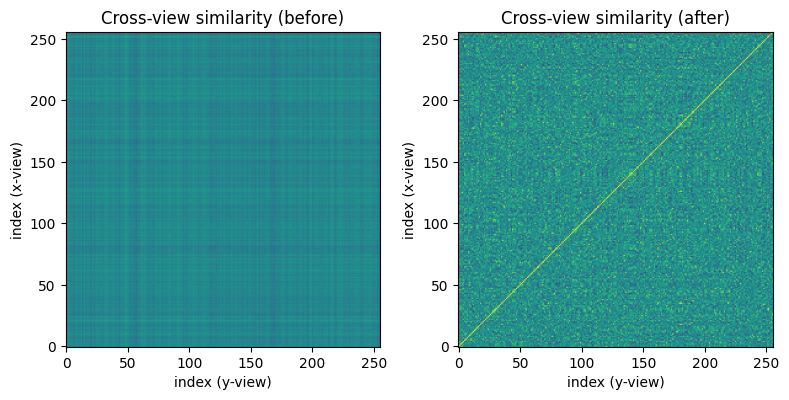

In [ ]:
# plot similarity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

im1 = ax1.imshow(S_before, vmin=-1, vmax=1, origin="lower")
ax1.set_title("Cross-view similarity (before)")
ax1.set_xlabel("index (y-view)")
ax1.set_ylabel("index (x-view)")

im2 = ax2.imshow(S_after, vmin=-1, vmax=1, origin="lower")
ax2.set_title("Cross-view similarity (after)")
ax2.set_xlabel("index (y-view)")
ax2.set_ylabel("index (x-view)")

#fig.colorbar(im2, ax=[ax1, ax2], fraction=0.05, pad=1.2)
plt.tight_layout()
plt.show()

In [ ]:
!pip install umap-learn

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-719584098.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)


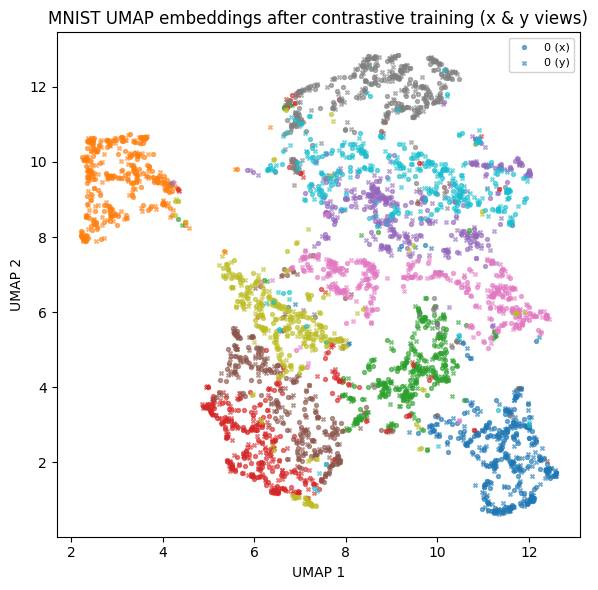

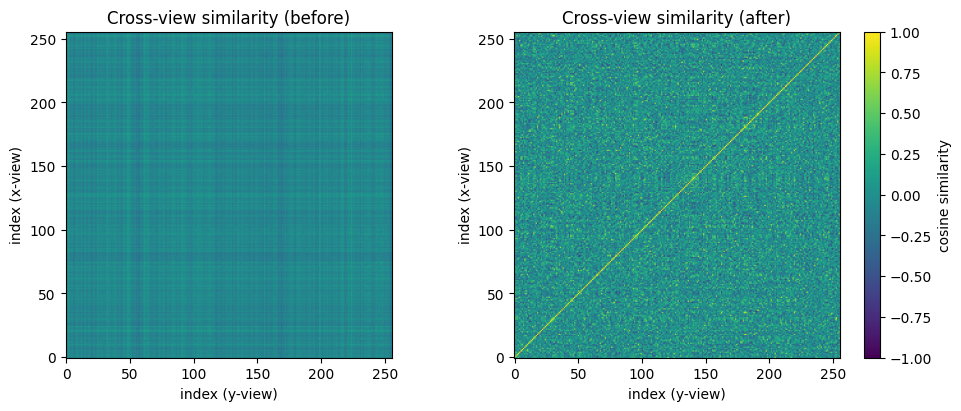

In [ ]:
# -----------------------------
# 9. UMAP visualization (after training, x + y overlapped)
# -----------------------------
import umap.umap_ as umap

# z_x, z_y, labels are from section 6 above
N_vis = z_x.shape[0]

# concatenate embeddings so UMAP sees both views jointly
Z_concat = np.concatenate([z_x, z_y], axis=0)  # shape (2*N_vis, d)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=SEED,
)
U = reducer.fit_transform(Z_concat)  # (2*N_vis, 2)

Ux = U[:N_vis]        # UMAP coords for x-view
Uy = U[N_vis:]        # UMAP coords for y-view

fig, ax = plt.subplots(figsize=(6, 6))
cmap = plt.cm.get_cmap("tab10", 10)

for d in range(10):
    mask = (labels == d)
    color = cmap(d)

    # x-view: circles
    ax.scatter(
        Ux[mask, 0],
        Ux[mask, 1],
        s=8,
        alpha=0.6,
        color=color,
        marker="o",
        label=f"{d} (x)" if d == 0 else None,
    )

    # y-view: crosses
    ax.scatter(
        Uy[mask, 0],
        Uy[mask, 1],
        s=8,
        alpha=0.6,
        color=color,
        marker="x",
        label=f"{d} (y)" if d == 0 else None,
    )

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("MNIST UMAP embeddings after contrastive training (x & y views)")

# compact legend: one entry for x and one for y
handles, labels_leg = ax.get_legend_handles_labels()
by_label = dict(zip(labels_leg, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=8, framealpha=0.9, loc="best")

plt.tight_layout()
plt.show()


# -----------------------------
# 10. Cleaner similarity matrices plot (before vs after)
# -----------------------------
# (Re-use S_before and S_after that you already computed above.)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im1 = axes[0].imshow(S_before, vmin=-1, vmax=1, origin="lower")
axes[0].set_title("Cross-view similarity (before)")
axes[0].set_xlabel("index (y-view)")
axes[0].set_ylabel("index (x-view)")

im2 = axes[1].imshow(S_after, vmin=-1, vmax=1, origin="lower")
axes[1].set_title("Cross-view similarity (after)")
axes[1].set_xlabel("index (y-view)")
axes[1].set_ylabel("index (x-view)")

# single colorbar on the far right (not over the "after" panel)
cbar = fig.colorbar(
    im2,
    ax=axes.ravel().tolist(),
    location="right",
    fraction=0.046,
    pad=0.02,
)
cbar.set_label("cosine similarity")

plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1532615046.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)


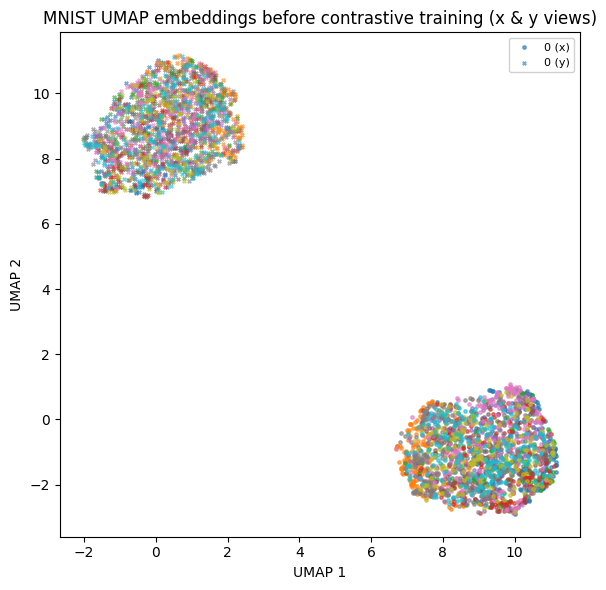

In [ ]:
# =============================
# UMAP BEFORE TRAINING (random encoders)
# =============================
from umap import UMAP

# fresh, randomly initialized encoders (approximate "before training")
f_before = MLPEncoder(input_dim=784, hidden_dim=512, proj_dim=32).to(device)
g_before = MLPEncoder(input_dim=784, hidden_dim=512, proj_dim=32).to(device)
f_before.eval()
g_before.eval()

with torch.no_grad():
    z_x_before = f_before(xs).cpu().numpy()  # (subset_size, 32)
    z_y_before = g_before(ys).cpu().numpy()  # (subset_size, 32)

# stack x and y embeddings so UMAP sees both views jointly
all_before = np.concatenate([z_x_before, z_y_before], axis=0)  # (2*subset_size, 32)

umap_before = UMAP(n_components=2, random_state=SEED)
all_before_2d = umap_before.fit_transform(all_before)  # (2*subset_size, 2)

zxb_2d = all_before_2d[:subset_size]        # x-view points
zyb_2d = all_before_2d[subset_size:]        # y-view points

# ---------- plot UMAP before training ----------
plt.figure(figsize=(6, 6))
cmap = plt.cm.get_cmap("tab10", 10)

for digit in range(10):
    mask = labels == digit

    # x-view: circles
    plt.scatter(
        zxb_2d[mask, 0],
        zxb_2d[mask, 1],
        s=6,
        alpha=0.6,
        color=cmap(digit),
        label=f"{digit} (x)" if digit == 0 else None,
    )

    # y-view: crosses
    plt.scatter(
        zyb_2d[mask, 0],
        zyb_2d[mask, 1],
        s=6,
        alpha=0.6,
        color=cmap(digit),
        marker="x",
        label=f"{digit} (y)" if digit == 0 else None,
    )

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("MNIST UMAP embeddings before contrastive training (x & y views)")

# only keep one entry per legend label
handles, labels_legend = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_legend, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.show()


# Example 3: Cross-Modal Alignment of Microbiome and Metabolome Data

[diag] device: cpu
[diag] MTB_MODE=all -> using 489 metabolite features
[diag] aligned samples: 164
[diag] shapes: N,Dx,Dy = 164 353 489
[diag] batch_size set to: 64
[train] epoch 001/300 loss=4.2060
[train] epoch 025/300 loss=0.0110
[train] epoch 050/300 loss=0.0018
[train] epoch 075/300 loss=0.0012
[train] epoch 100/300 loss=0.0008
[train] epoch 125/300 loss=0.0007
[train] epoch 150/300 loss=0.0006
[train] epoch 175/300 loss=0.0005
[train] epoch 200/300 loss=0.0005
[train] epoch 225/300 loss=0.0004
[train] epoch 250/300 loss=0.0004
[train] epoch 275/300 loss=0.0004
[train] epoch 300/300 loss=0.0003


/tmp/ipython-input-1631427954.py:75: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x, y)



=== Alignment metrics ===
[BEFORE] {'mean_pos_cos': 0.02801370993256569, 'median_pos_cos': 0.020853299647569656, 'mean_neg_cos': 0.022211294621229172, 'pos_minus_neg_mean': 0.005802415311336517, 'recall@1': 0.0, 'recall@5': 0.03048780487804878, 'median_rank': 84.5, 'median_pair_dist': 1.3993899822235107, 'pearson_dimwise_mean_r': 0.013459069654345512, 'pearson_dimwise_median_p': 0.37427628295427595, 'pearson_poscos_vs_ones_r': nan, 'pearson_poscos_vs_ones_p': nan} linear_probe_R2: -0.0480656698346138
[AFTER ] {'mean_pos_cos': 0.9757679104804993, 'median_pos_cos': 0.9761119484901428, 'mean_neg_cos': -0.00590647105127573, 'pos_minus_neg_mean': 0.9816743731498718, 'recall@1': 1.0, 'recall@5': 1.0, 'median_rank': 1.0, 'median_pair_dist': 0.21857744455337524, 'pearson_dimwise_mean_r': 0.9752177000045776, 'pearson_dimwise_median_p': 4.987980897236528e-109, 'pearson_poscos_vs_ones_r': nan, 'pearson_poscos_vs_ones_p': nan} linear_probe_R2: 0.8067507743835449


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1631427954.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


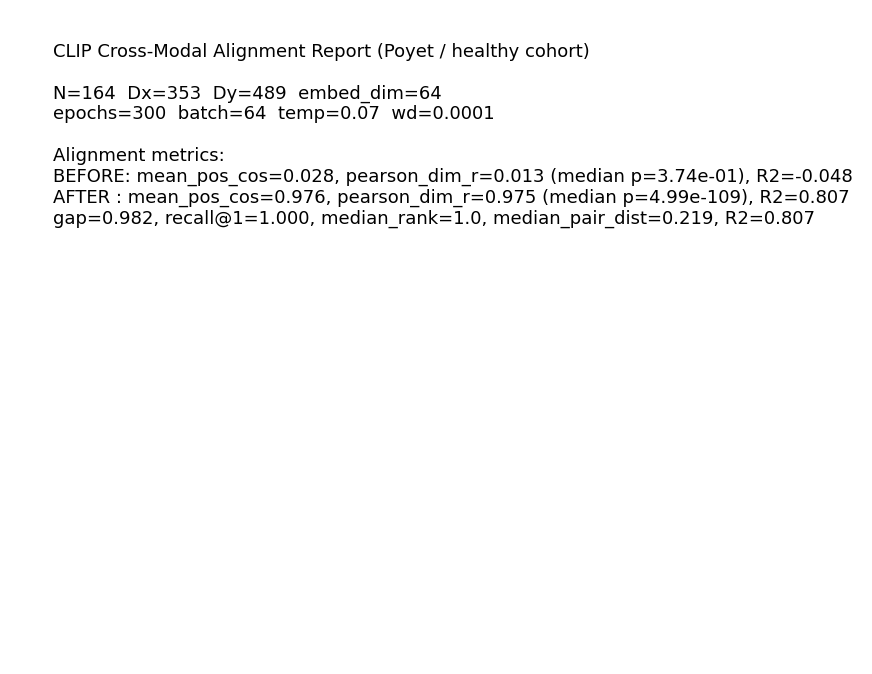

In [ ]:
# =========================
# DATA REQIUREMENTS:
# Upload these 3 files (exact names) from the Poyet 2019 dataset:
#   - metadata.tsv
#   - genera.counts.tsv
#   - mtb.tsv
# =========================

!pip -q install umap-learn

import os, random, re
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr


import umap
from google.colab import files

META_PATH  = "metadata.tsv"
X_PATH     = "genera.counts (1).tsv"
Y_PATH     = "mtb.tsv"

# -----------------------------
# 1) Config
# -----------------------------
SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[diag] device:", DEVICE)

# metabolomics selection
MTB_MODE = "all"            # "all" or "pattern"
MTB_PATTERN = r"^C18-neg_Cluster_"  # used only if MTB_MODE="pattern"

# optional microbiome prevalence filter (usually not needed for genera; useful if you swap to species later)
MICRO_PREVALENCE_K = None   # e.g. 5 or 10, or None

# CLIP hyperparams
EMBED_DIM = 64
HIDDEN_X = [512, 256]
HIDDEN_Y = [512, 256]
EPOCHS = 300
LR = 1e-3
TEMP = 0.07
WEIGHT_DECAY = 1e-4

# UMAP
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.10

# report
REPORT_PDF = "clip_alignment_report.pdf"
HEATMAP_MAX_N = 256  # subsample for similarity heatmaps
MAX_CONNECTOR_LINES = 250  # draw at most this many X<->Y connector lines to keep plot readable

# -----------------------------
# 2) Helpers
# -----------------------------
def pearson_with_p(x, y):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    r, p = pearsonr(x, y)
    return float(r), float(p)

def embedding_dimwise_pearson(Zx, Zy):
    # Pearson per embedding dimension across samples; returns mean r and mean p (p not strictly aggregatable, but useful)
    rs, ps = [], []
    for j in range(Zx.shape[1]):
        r, p = pearsonr(Zx[:, j], Zy[:, j])
        rs.append(r); ps.append(p)
    return float(np.mean(rs)), float(np.median(ps))


def sanitize_matrix(M: np.ndarray, name: str):
    M = M.astype(np.float32)
    M[~np.isfinite(M)] = np.nan

    col_median = np.nanmedian(M, axis=0)
    col_median = np.where(np.isfinite(col_median), col_median, 0.0)

    inds = np.where(np.isnan(M))
    if len(inds[0]) > 0:
        M[inds] = col_median[inds[1]]

    col_std = M.std(axis=0)
    keep = col_std > 0
    dropped = int((~keep).sum())
    if dropped > 0:
        print(f"[diag] Dropping {dropped} constant columns from {name}")
        M = M[:, keep]
    return M

def fit_umap(Z, seed=0):
    return umap.UMAP(
        n_neighbors=UMAP_N_NEIGHBORS,
        min_dist=UMAP_MIN_DIST,
        n_components=2,
        metric="euclidean",
        random_state=seed
    ).fit_transform(Z)

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim):
        super().__init__()
        dims = [in_dim] + list(hidden_dims)
        layers = []
        for i in range(len(dims) - 1):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.ReLU()]
        layers += [nn.Linear(dims[-1], out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return F.normalize(self.net(x), dim=-1)

def symmetric_infonce(zx, zy, temp=0.07):
    logits = (zx @ zy.T) / temp
    targets = torch.arange(zx.size(0), device=zx.device)
    return 0.5 * (F.cross_entropy(logits, targets) + F.cross_entropy(logits.T, targets))

def compute_metrics(Zx, Zy):
    S = Zx @ Zy.T
    pos = np.diag(S)
    neg = S[~np.eye(S.shape[0], dtype=bool)]

    # retrieval ranks
    ranks = []
    for i in range(S.shape[0]):
        order = np.argsort(-S[i, :])
        ranks.append(int(np.where(order == i)[0][0]) + 1)
    ranks = np.array(ranks)

    # paired distances (unit norm)
    d = np.sqrt(np.maximum(0.0, 2.0 - 2.0 * pos))

    # Pearson correlation (with p-value) of paired cosine similarities vs "perfect alignment" vector of 1s
    # This tests whether pos cosines vary in a way that's linearly associated with "being aligned" (all ones).
    # In practice, you may prefer the dimwise Pearson below as a more interpretable cross-modal correlation.
    ones = np.ones_like(pos)
    r_pos, p_pos = pearson_with_p(pos, ones)  # (note: this will often be undefined if pos has ~0 variance)

    # Dim-wise Pearson across samples (more interpretable)
    r_dim_mean, p_dim_median = embedding_dimwise_pearson(Zx, Zy)

    out = {
        "mean_pos_cos": float(pos.mean()),
        "median_pos_cos": float(np.median(pos)),
        "mean_neg_cos": float(neg.mean()),
        "pos_minus_neg_mean": float(pos.mean() - neg.mean()),
        "recall@1": float((ranks == 1).mean()),
        "recall@5": float((ranks <= 5).mean()),
        "median_rank": float(np.median(ranks)),
        "median_pair_dist": float(np.median(d)),
        # Pearson results
        "pearson_dimwise_mean_r": float(r_dim_mean),
        "pearson_dimwise_median_p": float(p_dim_median),
        "pearson_poscos_vs_ones_r": float(r_pos),
        "pearson_poscos_vs_ones_p": float(p_pos),
    }
    return out, S


def linear_probe_r2(Zx, Zy, seed=0):
    Xtr, Xte, Ytr, Yte = train_test_split(Zx, Zy, test_size=0.2, random_state=seed)
    model = Ridge(alpha=1.0)
    model.fit(Xtr, Ytr)
    return float(model.score(Xte, Yte))

def plot_umap_xy(pdf, Zx, Zy, title):
    # Fit UMAP on concatenated points so X and Y share the same 2D space
    Z = np.vstack([Zx, Zy])
    Z2 = fit_umap(Z, seed=SEED)
    N = Zx.shape[0]
    X2, Y2 = Z2[:N], Z2[N:]

    plt.figure(figsize=(8.0, 7.2))

    # connector lines (subsample if large)
    idx = np.arange(N)
    if N > MAX_CONNECTOR_LINES:
        rng = np.random.RandomState(SEED)
        idx = rng.choice(N, size=MAX_CONNECTOR_LINES, replace=False)

    for i in idx:
        plt.plot([X2[i,0], Y2[i,0]], [X2[i,1], Y2[i,1]], linewidth=0.5, alpha=0.20)

    # X modality: filled circles with edge
    plt.scatter(X2[:,0], X2[:,1], s=26, alpha=0.90,
                edgecolors="black", linewidths=0.25, label="X (microbiome)")
    # Y modality: X markers, thicker
    plt.scatter(Y2[:,0], Y2[:,1], s=30, alpha=0.90,
                marker="x", linewidths=1.2, label="Y (metabolome)")

    plt.title(title)
    plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
    plt.legend(loc="upper right", framealpha=0.95)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

def plot_heatmaps(pdf, S_before, S_after, max_n=256):
    n = S_before.shape[0]
    if n > max_n:
        rng = np.random.RandomState(SEED)
        idx = rng.choice(n, size=max_n, replace=False)
        idx.sort()
        Sb = S_before[np.ix_(idx, idx)]
        Sa = S_after[np.ix_(idx, idx)]
    else:
        Sb, Sa = S_before, S_after

    vmin, vmax = -1, 1

    plt.figure(figsize=(12, 5))
    ax1 = plt.subplot(1,2,1)
    im1 = ax1.imshow(Sb, vmin=vmin, vmax=vmax, origin="lower")
    ax1.set_title("Cosine similarity (X·Yᵀ) BEFORE")
    ax1.set_xlabel("Y index"); ax1.set_ylabel("X index")

    ax2 = plt.subplot(1,2,2)
    im2 = ax2.imshow(Sa, vmin=vmin, vmax=vmax, origin="lower")
    ax2.set_title("Cosine similarity (X·Yᵀ) AFTER")
    ax2.set_xlabel("Y index"); ax2.set_ylabel("X index")

    plt.colorbar(im2, ax=[ax1, ax2], fraction=0.046, pad=0.04)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

# -----------------------------
# 3) Load + align by Sample
# -----------------------------
meta = pd.read_csv(META_PATH, sep="\t")
Xdf  = pd.read_csv(X_PATH, sep="\t")
Ydf  = pd.read_csv(Y_PATH, sep="\t")

for df_, name in [(meta,"metadata"), (Xdf,"microbiome"), (Ydf,"mtb")]:
    if "Sample" not in df_.columns:
        raise ValueError(f"{name} missing required column: Sample")

# mtb select
mtb_cols = [c for c in Ydf.columns if c != "Sample"]
if MTB_MODE == "all":
    keep_cols = mtb_cols
    print(f"[diag] MTB_MODE=all -> using {len(keep_cols)} metabolite features")
elif MTB_MODE == "pattern":
    pat = re.compile(MTB_PATTERN, flags=re.IGNORECASE)
    keep_cols = [c for c in mtb_cols if pat.search(c)]
    print(f"[diag] MTB_MODE=pattern -> matched {len(keep_cols)} via {MTB_PATTERN}")
    if len(keep_cols) == 0:
        raise ValueError("Pattern matched 0 mtb columns.")
else:
    raise ValueError("MTB_MODE must be 'all' or 'pattern'.")

Ydf = Ydf[["Sample"] + keep_cols].copy()

meta_i = meta.set_index("Sample")
X_i = Xdf.set_index("Sample")
Y_i = Ydf.set_index("Sample")

common = meta_i.index.intersection(X_i.index).intersection(Y_i.index).sort_values()
print("[diag] aligned samples:", len(common))
if len(common) < 10:
    raise ValueError("Too few common Samples after intersection. Check Sample IDs across files.")

X_a = X_i.loc[common].copy()
Y_a = Y_i.loc[common].copy()

if MICRO_PREVALENCE_K is not None:
    nz = (X_a != 0).sum(axis=0)
    X_a = X_a.loc[:, nz >= MICRO_PREVALENCE_K]
    print(f"[diag] prevalence filter kept {X_a.shape[1]} X features (>= {MICRO_PREVALENCE_K} nonzeros)")

# matrices
X_raw = sanitize_matrix(X_a.to_numpy(dtype=np.float32), "X_raw (microbiome)")
Y_raw = sanitize_matrix(Y_a.to_numpy(dtype=np.float32), "Y_raw (metabolomics)")

# preprocess
X = np.log1p(X_raw)
Y = Y_raw

X = StandardScaler().fit_transform(X).astype(np.float32)
Y = StandardScaler().fit_transform(Y).astype(np.float32)

N, Dx = X.shape
_, Dy = Y.shape
print("[diag] shapes: N,Dx,Dy =", N, Dx, Dy)

# critical fix: batch size must be <= N and drop_last must be False
BATCH_SIZE = min(64, N)
print("[diag] batch_size set to:", BATCH_SIZE)

# -----------------------------
# 4) Build encoders ONCE; compute TRUE BEFORE embeddings
# -----------------------------
fx = MLP(Dx, HIDDEN_X, EMBED_DIM).to(DEVICE)
gy = MLP(Dy, HIDDEN_Y, EMBED_DIM).to(DEVICE)

X_t = torch.from_numpy(X).to(DEVICE)
Y_t = torch.from_numpy(Y).to(DEVICE)

fx.eval(); gy.eval()
with torch.no_grad():
    Zx_before = fx(X_t).cpu().numpy()
    Zy_before = gy(Y_t).cpu().numpy()

# -----------------------------
# 5) Train CLIP
# -----------------------------
class Paired(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.Y[i]

ds = Paired(X, Y)
loader = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

opt = torch.optim.AdamW(
    list(fx.parameters()) + list(gy.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

for ep in range(EPOCHS):
    fx.train(); gy.train()
    running = 0.0; steps = 0
    for xb, yb in loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        zx = fx(xb); zy = gy(yb)
        loss = symmetric_infonce(zx, zy, temp=TEMP)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item(); steps += 1
    if (ep+1) % 25 == 0 or ep == 0:
        print(f"[train] epoch {ep+1:03d}/{EPOCHS} loss={running/max(1,steps):.4f}")

# -----------------------------
# 6) AFTER embeddings
# -----------------------------
fx.eval(); gy.eval()
with torch.no_grad():
    Zx_after = fx(X_t).cpu().numpy()
    Zy_after = gy(Y_t).cpu().numpy()

# -----------------------------
# 7) Metrics + PDF report
# -----------------------------
m_before, S_before = compute_metrics(Zx_before, Zy_before)
m_after,  S_after  = compute_metrics(Zx_after,  Zy_after)
r2_before = linear_probe_r2(Zx_before, Zy_before, seed=SEED)
r2_after  = linear_probe_r2(Zx_after,  Zy_after,  seed=SEED)

print("\n=== Alignment metrics ===")
print("[BEFORE]", m_before, "linear_probe_R2:", r2_before)
print("[AFTER ]", m_after,  "linear_probe_R2:", r2_after)

plt.figure(figsize=(11, 8.5))
plt.axis("off")
txt = (
        "CLIP Cross-Modal Alignment Report (Poyet / healthy cohort)\n\n"
        f"N={N}  Dx={Dx}  Dy={Dy}  embed_dim={EMBED_DIM}\n"
        f"epochs={EPOCHS}  batch={BATCH_SIZE}  temp={TEMP}  wd={WEIGHT_DECAY}\n\n"
        "Alignment metrics:\n"
        f"BEFORE: mean_pos_cos={m_before['mean_pos_cos']:.3f}, "
        f"pearson_dim_r={m_before['pearson_dimwise_mean_r']:.3f} (median p={m_before['pearson_dimwise_median_p']:.2e}), "
        f"R2={r2_before:.3f}\n"
        f"AFTER : mean_pos_cos={m_after['mean_pos_cos']:.3f}, "
        f"pearson_dim_r={m_after['pearson_dimwise_mean_r']:.3f} (median p={m_after['pearson_dimwise_median_p']:.2e}), "
        f"R2={r2_after:.3f}\n"
        f"gap={m_after['pos_minus_neg_mean']:.3f}, "
        f"recall@1={m_after['recall@1']:.3f}, "
        f"median_rank={m_after['median_rank']:.1f}, "
        f"median_pair_dist={m_after['median_pair_dist']:.3f}, "
        f"R2={r2_after:.3f}\n"
)
plt.text(0.05, 0.95, txt, va="top", fontsize=13)

# UMAP before/after with modality highlighting + connector lines
plot_umap_xy(pdf, Zx_before, Zy_before, "UMAP BEFORE training (X vs Y + pair connectors)")
plot_umap_xy(pdf, Zx_after,  Zy_after,  "UMAP AFTER training (X vs Y + pair connectors)")

# cosine similarity heatmaps before/after
plot_heatmaps(pdf, S_before, S_after, max_n=HEATMAP_MAX_N)
plt.show()
